In [62]:
import pandas as pd
import numpy as np
import json
import re

In [63]:
df_restaurantes = pd.read_parquet(r'Datawarehouse\restaurantes.parquet')


In [64]:
# df_restaurantes = df_restaurantes[df_restaurantes['nombre'] =="Subway"]
df_restaurantes['origen'] = df_restaurantes['id_restaurante'].apply(len)
df_restaurantes['origen'] =  df_restaurantes['id_restaurante'].apply(lambda x: 1 if len(x) > 22 else 0)
df_restaurantes.sample(1)

,id_restaurante,id_estado,nombre,categorias,cantidad_resenas,latitud,longitud,atributos,calificacion,origen
181552,0x885a6f6467dcc295:0x53d5156ebe5567eb,42.0,Domino's Pizza,"['Pizza delivery', 'Delivery Restaurant', 'Tak...",55,36.146097,-82.415217,"{'AcceptsInsurance': None, 'Accessibility': ['...",3.300781,1


In [65]:
df_restaurantes['origen'].value_counts()

origen
1    97744
0    14170
Name: count, dtype: int64

In [66]:
# df_restaurantes = df_restaurantes[df_restaurantes.nombre.str.contains('Subway')]
# df_restaurantes = df_restaurantes[df_restaurantes.nombre.str.lower().str.contains('subway')]

In [67]:
# pd.DataFrame(pd.json_normalize(df_restaurantes.query("origen == 'Y'").atributos).isna().sum(),columns=['nulos']).sort_values(by="nulos")

In [68]:
# nulos > 95738
columnas = pd.DataFrame(pd.json_normalize(df_restaurantes.atributos).isna().sum(),columns=['nulos']).index.to_list()

In [69]:
columnas = ['Accessibility',
 'Amenities',
 'Atmosphere',
 'Crowd',
 'Dining options',
 'Health & safety',
 'Highlights',
 'Offerings',
 'Payments',
 'Popular for',
 'Service options']

### 1. Atributos

In [70]:
df_atributos = pd.json_normalize(df_restaurantes.atributos).reset_index()[columnas].fillna(np.ndarray([]))

In [71]:
for col in columnas:
    df_atributos[col] = df_atributos[col].apply(str)
    df_atributos[col] = df_atributos[col].apply(lambda c: "[]" if c == '0.0' else c)
    # df_atributos[col] = df_atributos[col].apply(json.loads)
    

In [72]:
df_atributos.sample(3)

,Accessibility,Amenities,Atmosphere,Crowd,Dining options,Health & safety,Highlights,Offerings,Payments,Popular for,Service options
7985,[],[],[],[],[],[],[],[],[],[],[]
95860,[],[],['Casual'],[],[],[],[],[],[],['Solo dining'],['No-contact delivery' 'Delivery' 'Takeout' 'D...
44895,['Wheelchair accessible entrance' 'Wheelchair ...,['Good for kids' 'High chairs' 'Restroom' 'Wi-...,['Casual'],['Family-friendly' 'Groups' 'Tourists'],['Breakfast' 'Lunch' 'Dinner' 'Catering' 'Dess...,[],['LGBTQ friendly'],"['Coffee' 'Comfort food' 'Healthy options' ""Ki...",['Debit cards' 'NFC mobile payments' 'Credit c...,['Lunch' 'Dinner' 'Solo dining'],['Delivery' 'Takeout' 'Dine-in']


#### 1.2 Accessibility

In [73]:
df_atributos['Accessibility'] = df_atributos['Accessibility'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

df_atributos['Accessibility'].sample(3)

61203    [Wheelchair accessible entrance, Wheelchair ac...
48203    [Wheelchair accessible elevator, Wheelchair ac...
34943                                                   []
Name: Accessibility, dtype: object

In [74]:
columnas_accesibilidad =  df_atributos['Accessibility'].explode().unique()[1:].tolist()


In [75]:
df_accesibilidad = pd.DataFrame([[False] * len(columnas_accesibilidad)] * df_atributos.shape[0], columns=columnas_accesibilidad)

In [76]:
df_accesibilidad.sample(3)

,Wheelchair accessible entrance,Wheelchair accessible parking lot,Wheelchair accessible seating,Wheelchair accessible restroom,Wheelchair accessible elevator,Wheelchair-accessible car park,Wheelchair-accessible entrance,Wheelchair-accessible seating,Wheelchair-accessible toilet,Wheelchair-accessible lift,Assisted listening devices
64907,False,False,False,False,False,False,False,False,False,False,False
63680,False,False,False,False,False,False,False,False,False,False,False
98664,False,False,False,False,False,False,False,False,False,False,False


In [77]:
for i, row in enumerate(df_atributos['Accessibility']):
    for j, val in enumerate(row):
        df_accesibilidad.loc[i, val] = True


In [78]:
df_restaurantes = df_restaurantes.reset_index().reset_index().drop(columns=['index']).rename({'level_0': 'index'}, axis=1, errors='ignore')
df_accesibilidad.reset_index().merge(df_restaurantes, on="index").sample(3)


,index,Wheelchair accessible entrance,Wheelchair accessible parking lot,Wheelchair accessible seating,Wheelchair accessible restroom,Wheelchair accessible elevator,Wheelchair-accessible car park,Wheelchair-accessible entrance,Wheelchair-accessible seating,Wheelchair-accessible toilet,...,id_restaurante,id_estado,nombre,categorias,cantidad_resenas,latitud,longitud,atributos,calificacion,origen
68549,68549,True,False,False,False,False,False,False,False,False,...,0x87b94dffd897a0c5:0x47d578c87ed622f1,16.0,Panda Express,"['Chinese restaurant', 'Restaurant']",37,38.423923,-96.218972,"{'AcceptsInsurance': None, 'Accessibility': ['...",2.599609,1
96188,96188,True,True,False,False,False,False,False,False,False,...,0x8830f1e1e406b033:0x8862990d225f4454,35.0,Subway,"['Sandwich shop', 'Caterer', 'Fast food restau...",98,41.465301,-81.760180,"{'AcceptsInsurance': None, 'Accessibility': ['...",3.400391,1
18028,18028,True,True,False,False,False,False,False,False,False,...,0x52baa75adbafd84f:0xa07168a761605d18,23.0,"Sullivan Candy and Supply, Inc.","['Restaurant supply store', 'General store', '...",24,47.419739,-92.926793,"{'AcceptsInsurance': None, 'Accessibility': ['...",4.199219,1


In [79]:
df_accesibilidad.columns = ["access_" + c for c in df_accesibilidad.columns]
union = df_accesibilidad.reset_index().merge(df_restaurantes, on="index")

In [80]:
union.sample(3)

,index,access_Wheelchair accessible entrance,access_Wheelchair accessible parking lot,access_Wheelchair accessible seating,access_Wheelchair accessible restroom,access_Wheelchair accessible elevator,access_Wheelchair-accessible car park,access_Wheelchair-accessible entrance,access_Wheelchair-accessible seating,access_Wheelchair-accessible toilet,...,id_restaurante,id_estado,nombre,categorias,cantidad_resenas,latitud,longitud,atributos,calificacion,origen
62953,62953,False,False,False,False,False,False,True,True,False,...,0x8085794a871e3d17:0x897a834035f38939,5.0,Solano Junction,"['Breakfast restaurant', 'Brunch restaurant', ...",158,37.891108,-122.287588,"{'AcceptsInsurance': None, 'Accessibility': ['...",4.199219,1
52493,52493,True,False,False,False,False,False,False,False,False,...,0x88672e9003bb9da7:0xf2924cd9b8b44ebf,42.0,Subway,"['Sandwich shop', 'Caterer', 'Fast food restau...",38,35.930257,-85.488145,"{'AcceptsInsurance': None, 'Accessibility': ['...",4.101562,1
24446,24446,True,True,False,False,False,False,False,False,False,...,0x8624c59295967693:0xd247bd3cb3e64f65,18.0,Point Blue BBQ,"['Restaurant', 'Barbecue restaurant']",5,30.624422,-92.291570,"{'AcceptsInsurance': None, 'Accessibility': ['...",5.000000,1


In [81]:
df_atributos['Accessibility'].iloc[8536]

[]

#### 1.3 DF Amenities

In [82]:
df_atributos['Amenities'] = df_atributos['Amenities'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

columnas_amenities = df_atributos['Amenities'].explode().unique()[1:].tolist()
df_amenities = pd.DataFrame([[False] * len(columnas_amenities)] * df_atributos.shape[0], columns=columnas_amenities)

for i, row in enumerate(df_atributos['Amenities']):
    for j, val in enumerate(row):
        df_amenities.loc[i, val] = True

df_amenities.columns = ["amen_" + c for c in df_amenities.columns]
union = df_amenities.reset_index().merge(union, on="index")

#### 1.4 Atmosphere

In [83]:
df_atributos['Atmosphere'] = df_atributos['Atmosphere'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

columnas_atmosphere = df_atributos['Atmosphere'].explode().unique()[1:].tolist()

df_atmosphere = pd.DataFrame([[False] * len(columnas_atmosphere)] * df_atributos.shape[0], columns=columnas_atmosphere)

for i, row in enumerate(df_atributos['Atmosphere']):
    for j, val in enumerate(row):
        df_atmosphere.loc[i, val] = True

df_atmosphere.columns = ["atmos_" + c for c in df_atmosphere.columns]
union = df_atmosphere.reset_index().merge(union, on="index")

#### 1.5 Crowd

In [84]:
df_atributos['Crowd'] = df_atributos['Crowd'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

columnas_crowd = df_atributos['Crowd'].explode().unique()[1:].tolist()

df_crowd = pd.DataFrame([[False] * len(columnas_crowd)] * df_atributos.shape[0], columns=columnas_crowd)

for i, row in enumerate(df_atributos['Crowd']):
    for j, val in enumerate(row):
        df_crowd.loc[i, val] = True

df_crowd.columns = ["crowd_" + c for c in df_crowd.columns]
union = df_crowd.reset_index().merge(union, on="index")       

#### 1.6 Dinning Options

In [85]:
df_atributos['Dining options'] = df_atributos['Dining options'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

columnas_dining = df_atributos['Dining options'].explode().unique()[1:].tolist()
df_dining = pd.DataFrame([[False] * len(columnas_dining)] * df_atributos.shape[0], columns=columnas_dining)

for i, row in enumerate(df_atributos['Dining options']):
    for j, val in enumerate(row):
        df_dining.loc[i, val] = True

df_dining.columns = ["dining_" + c for c in df_dining.columns]
union = df_dining.reset_index().merge(union, on="index")

#### 1.7 Health & safety

In [86]:
df_atributos['Health & safety'] = df_atributos['Health & safety'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

columnas_health = df_atributos['Health & safety'].explode().unique()[1:].tolist()

df_health = pd.DataFrame([[False] * len(columnas_health)] * df_atributos.shape[0], columns=columnas_health)

for i, row in enumerate(df_atributos['Health & safety']):
    for j, val in enumerate(row):
        df_health.loc[i, val] = True

df_health.columns = ["health_" + c for c in df_health.columns]
union = df_health.reset_index().merge(union, on="index")        


#### 1.8 Highlights

In [87]:
df_atributos['Highlights'] = df_atributos['Highlights'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

columnas_high = df_atributos['Highlights'].explode().unique()[1:].tolist()

df_high = pd.DataFrame([[False] * len(columnas_high)] * df_atributos.shape[0], columns=columnas_high)

for i, row in enumerate(df_atributos['Highlights']):
    for j, val in enumerate(row):
        df_high.loc[i, val] = True

df_high.columns = ["high_" + c for c in df_high.columns]
union = df_high.reset_index().merge(union, on="index")

#### 1.9 Offerings

In [88]:
df_atributos['Offerings'] = df_atributos['Offerings'].apply(lambda r: r.replace("Kids'", "Kids"))

df_atributos['Offerings'] = df_atributos['Offerings'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

columnas_offerings = df_atributos['Offerings'].explode().unique()[1:].tolist()

df_offering = pd.DataFrame([[False] * len(columnas_offerings)] * df_atributos.shape[0], columns=columnas_offerings)

for i, row in enumerate(df_atributos['Offerings']):
    for j, val in enumerate(row):
        df_offering.loc[i, val] = True

df_offering.columns = ["offer_" + c for c in df_offering.columns]
union = df_offering.reset_index().merge(union, on="index")

#### 1.10 Payments

In [89]:
df_atributos['Payments'] = df_atributos['Payments'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

columnas_payments = df_atributos['Payments'].explode().unique()[1:].tolist()

df_payments = pd.DataFrame([[False] * len(columnas_payments)] * df_atributos.shape[0], columns=columnas_payments)

for i, row in enumerate(df_atributos['Payments']):
    for j, val in enumerate(row):
        df_payments.loc[i, val] = True

df_payments.columns = ["pay_" + c for c in df_payments.columns]
union = df_payments.reset_index().merge(union, on="index")

#### 1.11 Popular for

In [90]:
df_atributos['Popular for'] = df_atributos['Popular for'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

columnas_popular = df_atributos['Popular for'].explode().unique()[1:].tolist()

df_popular = pd.DataFrame([[False] * len(columnas_popular)] * df_atributos.shape[0], columns=columnas_popular)

for i, row in enumerate(df_atributos['Popular for']):
    for j, val in enumerate(row):
        df_popular.loc[i, val] = True

df_popular.columns = ["popular_" + c for c in df_popular.columns]
union = df_popular.reset_index().merge(union, on="index")



#### 1.12 Service Options

In [91]:
df_atributos['Service options'] = df_atributos['Service options'].apply(lambda s: re.sub(r"'", "\"", s)).apply(lambda s: re.sub(r'"\s*"','","', s)).apply(json.loads)

columnas_service = df_atributos['Service options'].explode().unique()[1:].tolist()

df_service = pd.DataFrame([[False] * len(columnas_service)] * df_atributos.shape[0], columns=columnas_service)

for i, row in enumerate(df_atributos['Service options']):
    for j, val in enumerate(row):
        df_service.loc[i, val] = True

df_service.columns = ["service_" + c for c in df_service.columns]

union = df_service.reset_index().merge(union, on="index")

In [92]:
# union.to_excel("union.xlsx")

# 2. Machine Learning

## 2.1 Tareas Previas

### 2.1.1 Importaciones

In [93]:
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn import preprocessing


from sklearn.datasets import make_classification
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import cross_validate


from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier

### 2.1.2 Recorte de Features

Subset de columnas features, que son la columna atributos desplegada

In [94]:
subset = [col for col in union.columns if '_' in col and col not in ['id_restaurante', 'id_estado', 'id_restaurantes', 'cantidad_resenas'] ]


In [138]:
union

,index,service_Outdoor seating,service_Curbside pickup,service_No-contact delivery,service_Delivery,service_Takeout,service_Dine-in,service_Drive-through,service_In-store pickup,service_In-store shopping,...,id_restaurante,id_estado,nombre,categorias,cantidad_resenas,latitud,longitud,atributos,calificacion,origen
0,0,False,False,False,False,False,False,False,False,False,...,MTSW4McQd7CbVtyjqoe9mw,38.0,St Honore Pastries,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",80,39.955505,-75.155564,"{'AcceptsInsurance': None, 'Accessibility': No...",4.000000,0
1,1,False,False,False,False,False,False,False,False,False,...,kfNv-JZpuN6TVNSO6hHdkw,14.0,Hibachi Express,"Steakhouses, Asian Fusion, Restaurants",20,39.904320,-86.053080,"{'AcceptsInsurance': None, 'Accessibility': No...",4.000000,0
2,2,False,False,False,False,False,False,False,False,False,...,sqSqqLy0sN8n2IZrAbzidQ,42.0,Domino's Pizza,"Pizza, Chicken Wings, Sandwiches, Restaurants",8,36.464747,-86.659187,"{'AcceptsInsurance': None, 'Accessibility': No...",3.500000,0
3,3,False,False,False,False,False,False,False,False,False,...,aPNXGTDkf-4bjhyMBQxqpQ,38.0,Craft Hall,"Eatertainment, Arts & Entertainment, Brewpubs,...",65,39.962582,-75.135657,"{'AcceptsInsurance': None, 'Accessibility': No...",3.500000,0
4,4,False,False,False,False,False,False,False,False,False,...,seKihQKpGGnCeLuELRQPSQ,14.0,Twin Peaks,"Sports Bars, American (New), American (Traditi...",257,39.906295,-86.047463,"{'AcceptsInsurance': None, 'Accessibility': No...",3.500000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111909,111909,False,True,False,False,True,True,False,False,False,...,0x87d246f0f9aa080f:0x5023e31e61a87f1c,4.0,Subway,"['Sandwich shop', 'Caterer', 'Fast food restau...",125,35.491484,-92.034937,"{'AcceptsInsurance': None, 'Accessibility': ['...",4.199219,1
111910,111910,False,False,False,False,True,False,False,False,False,...,0x87d28d5aa640a9c5:0x3c9cc5d3a99de80c,4.0,"Simple Simon's Pizza - Vilonia, AR","['Pizza Takeout', 'Italian restaurant', 'Pizza...",38,35.081871,-92.207739,"{'AcceptsInsurance': None, 'Accessibility': ['...",4.500000,1
111911,111911,False,False,False,False,True,False,False,False,False,...,0x88d9dd6e78851851:0x849dcf273582261c,9.0,Subpreme Grill,"['Sandwich shop', 'Fast food restaurant', 'Tak...",393,25.506121,-80.438215,"{'AcceptsInsurance': None, 'Accessibility': ['...",4.300781,1
111912,111912,False,False,False,True,True,True,True,False,False,...,0x89c6c4072624d2a9:0x4437b2d55e9a5811,38.0,Dunkin',"['Coffee shop', 'Bagel shop', 'Bakery', 'Break...",348,39.923594,-75.245269,"{'AcceptsInsurance': None, 'Accessibility': ['...",4.000000,1


Seleccionamos las que tienen una tasa de ocurrencia del 5% o más

In [95]:
tasa = pd.Series(union[subset].sum()/len(union))
columnas = tasa[tasa >=0.05].index.tolist()

Elegimos las columnas que vamos a utilizar

In [96]:
columnas_filtradas = ['index']  + columnas + pd.Series(union.columns).reset_index().loc[159:,0].tolist()
df = union[columnas_filtradas]

In [97]:
df_atributos_filtrado = df.reset_index().merge(df_restaurantes.reset_index(), on='index')

In [98]:
le = LabelEncoder()
le.fit(["California", "Florida","New York", "Pensilvania", "Texas"])

le.transform(["California","New York", "Pensilvania", "Texas",  "Florida"])

array([0, 2, 3, 4, 1])

In [99]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
# enc.fit(range(1,51).reshape(-1,1))
# enc.fit(df_restaurantes['id_estado'].reset_index())

one_hot_encoded = encoder.fit_transform(df[['id_estado']].astype(int))
# one_hot_encoded
df_one_hot_encoded = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(['id_estado']))
# df[['id_estado']]

df = pd.concat([df, df_one_hot_encoded], axis=1)

In [100]:
columnas_service = [col for col in df_atributos_filtrado.columns if col.startswith('service')]

columnas_access = [col for col in df_atributos_filtrado.columns if col.startswith('access')]
columnas_amen = [col for col in df_atributos_filtrado.columns if col.startswith('amen')]
columnas_atmos = [col for col in df_atributos_filtrado.columns if col.startswith('atmos')]
columnas_crowd = [col for col in df_atributos_filtrado.columns if col.startswith('crowd')]
columnas_dining = [col for col in df_atributos_filtrado.columns if col.startswith('dining')]
columnas_health = [col for col in df_atributos_filtrado.columns if col.startswith('health')]
columnas_high = [col for col in df_atributos_filtrado.columns if col.startswith('high')]
columnas_offer = [col for col in df_atributos_filtrado.columns if col.startswith('offer')]
columnas_pay = [col for col in df_atributos_filtrado.columns if col.startswith('pay')]
columnas_popular = [col for col in df_atributos_filtrado.columns if col.startswith('popular')]


# with open('service_sql.txt', 'w') as f:
#     for i, row in df_atributos_filtrado.iterrows():
#         for c in columnas_service:
#             if df_atributos_filtrado.loc[i, c] == 1:
#                 f.write(f"('{df_atributos_filtrado.loc[i,'id_restaurante']}', '{c[8:]}');\n")

# with open('access_sql.txt', 'w') as f:
#     for i, row in df_atributos_filtrado.iterrows():
#         for c in columnas_access:
#             if df_atributos_filtrado.loc[i, c] == 1:
#                 f.write(f"('{df_atributos_filtrado.loc[i,'id_restaurante']}', '{c[7:]}');\n")

# with open('amenities_sql.txt', 'w') as f:
#     for i, row in df_atributos_filtrado.iterrows():
#         for c in columnas_amen:
#             if df_atributos_filtrado.loc[i, c] == 1:
#                 f.write(f"('{df_atributos_filtrado.loc[i,'id_restaurante']}', '{c[5:]}');\n")                

# with open('atmosphere_sql.txt', 'w') as f:
#     for i, row in df_atributos_filtrado.iterrows():
#         for c in columnas_atmos:
#             if df_atributos_filtrado.loc[i, c] == 1:
#                 f.write(f"('{df_atributos_filtrado.loc[i,'id_restaurante']}', '{c[6:]}');\n")          

# with open('crowd_sql.txt', 'w') as f:
#     for i, row in df_atributos_filtrado.iterrows():
#         for c in columnas_crowd:
#             if df_atributos_filtrado.loc[i, c] == 1:
#                 f.write(f"('{df_atributos_filtrado.loc[i,'id_restaurante']}', '{c[6:]}');\n") 

# with open('dining_sql.txt', 'w') as f:
#     for i, row in df_atributos_filtrado.iterrows():
#         for c in columnas_dining:
#             if df_atributos_filtrado.loc[i, c] == 1:
#                 f.write(f"('{df_atributos_filtrado.loc[i,'id_restaurante']}', '{c[7:]}');\n") 

# with open('health_sql.txt', 'w') as f:
#     for i, row in df_atributos_filtrado.iterrows():
#         for c in columnas_health:
#             if df_atributos_filtrado.loc[i, c] == 1:
#                 f.write(f"('{df_atributos_filtrado.loc[i,'id_restaurante']}', '{c[7:]}');\n")

# with open('high_sql.txt', 'w') as f:
#     for i, row in df_atributos_filtrado.iterrows():
#         for c in columnas_high:
#             if df_atributos_filtrado.loc[i, c] == 1:
#                 f.write(f"('{df_atributos_filtrado.loc[i,'id_restaurante']}', '{c[5:]}');\n")

# with open('offer_sql.txt', 'w') as f:
#     for i, row in df_atributos_filtrado.iterrows():
#         for c in columnas_offer:
#             if df_atributos_filtrado.loc[i, c] == 1:
#                 f.write(f"('{df_atributos_filtrado.loc[i,'id_restaurante']}', '{c[6:]}');\n")

# with open('pay_sql.txt', 'w') as f:
#     for i, row in df_atributos_filtrado.iterrows():
#         for c in columnas_pay:
#             if df_atributos_filtrado.loc[i, c] == 1:
#                 f.write(f"('{df_atributos_filtrado.loc[i,'id_restaurante']}', '{c[4:]}');\n")

# with open('popular_sql.txt', 'w') as f:
#     for i, row in df_atributos_filtrado.iterrows():
#         for c in columnas_popular:
#             if df_atributos_filtrado.loc[i, c] == 1:
#                 f.write(f"('{df_atributos_filtrado.loc[i,'id_restaurante']}', '{c[8:]}');\n")


In [101]:
# import pandas as pd

# # Definir las categorías y las correspondientes subcadenas de corte
# categorias = {
#     'service': 8,
#     'access': 7,
#     'amen': 5,
#     'atmos': 6,
#     'crowd': 6,
#     'dining': 7,
#     'health': 7,
#     'high': 5,
#     'offer': 6,
#     'pay': 4,
#     'popular': 8
# }

# # Filtrar columnas por cada categoría
# columnas = {cat: [col for col in df_atributos_filtrado.columns if col.startswith(cat)] for cat in categorias.keys()}

# # Variable para seguir la numeración de las inserciones
# id_counter = 1

# # Crear las instrucciones SQL en un archivo
# with open('inserts_atributos.sql', 'w') as f:
#     for cat, substr_len in categorias.items():
#         for i, row in df_atributos_filtrado.iterrows():
#             for col in columnas[cat]:
#                 if df_atributos_filtrado.loc[i, col] == 1:
#                     f.write(f"INSERT INTO atributos VALUES ({id_counter}, '{df_atributos_filtrado.loc[i,'id_restaurante']}', '{cat}', '{col[substr_len:]}');\n")
#                     id_counter += 1


### 2.1.3 Downgrade de calificacion

Preparación del umbral, que divida a la calificación de positiva a negativa.

[]

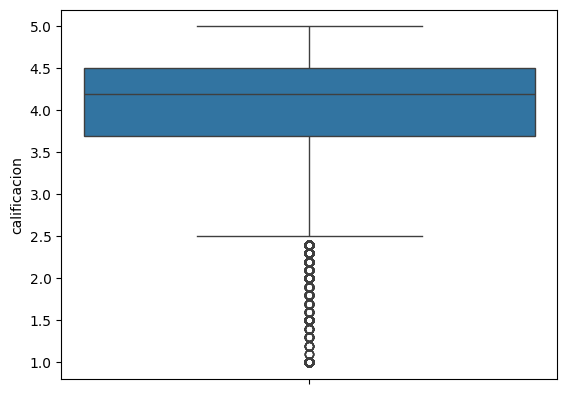

In [102]:
fig = sns.boxplot(df_restaurantes['calificacion'])
fig.plot()

In [103]:
df['calificacion'].describe()

count    111914.000000
mean          4.053937
std           0.665589
min           1.000000
25%           3.699219
50%           4.199219
75%           4.500000
max           5.000000
Name: calificacion, dtype: float64

Decidimos utilizar el promedio como umbral

In [104]:
umbral = df['calificacion'].mean()

In [105]:
df.loc[:, 'calificacion'] = df.loc[:, 'calificacion'].apply(lambda x: 1 if x >= umbral else 0)

In [106]:
df.loc[:, 'calificacion'] = df.loc[:, 'calificacion'].astype(int)

### 2.1.4 Selección de Features para el ML

In [107]:
dropear = ["nombre","index", "id_restaurante","categorias", "atributos","id_estado", "cantidad_resenas"]
# dropear = ["index", "id_restaurante","categorias", "atributos", "nombre"]

df = df.drop(columns=dropear)


### 2.1.5 Over y Under Sampling

In [108]:
df['calificacion'].value_counts()

calificacion
1.0    62971
0.0    48943
Name: count, dtype: int64

In [109]:
df = pd.concat([df.query("calificacion == 1").sample(48943),df.query("calificacion == 0")])

In [110]:
df['calificacion'].value_counts()

calificacion
1.0    48943
0.0    48943
Name: count, dtype: int64

In [111]:
# X_subway = df.query("nombre == 'Subway'").drop(['calificacion', 'nombre'], axis=1)
# y_subway = df.query("nombre == 'Subway'").loc[:, 'calificacion']
# X_nsubway = df.query("nombre != 'Subway'").drop(['calificacion', 'nombre'], axis=1)
# y_nsubway = df.query("nombre != 'Subway'").loc[:, 'calificacion']

# X_train, X_test, y_train, y_test = X_nsubway, X_subway, y_nsubway, y_subway

In [112]:
df[df.columns[:-4]] = df[df.columns[:-4]].astype(int)

## 2.2 Modelos

### 2.2.1 Regresión Logística

In [113]:
scores = dict()

X = df.drop(['calificacion'], axis=1)
y = df['calificacion'] 

In [114]:
# X = df[['atmos_Cozy', 'longitud', 'latitud', 'origen', 'service_Outdoor seating', 'offer_Small plates',
#         'dining_Lunch', 'service_Dine-in', 'dining_Dessert', 'service_No-contact delivery',
#         'access_Wheelchair accessible entrance', 'pay_NFC mobile payments', 'service_Curbside pickup',
#         'offer_Kids menu', 'crowd_Groups', 'crowd_Tourists', 'health_Mask required', 'offer_Coffee',
#         'offer_Vegetarian options', 'service_Delivery', 'atmos_Casual', 'service_Takeout',
#         'offer_Late-night food', 'amen_Good for kids', 'offer_Comfort food', 'pay_Credit cards',
#         'health_Staff wear masks', 'service_Drive-through', 'access_Wheelchair accessible parking lot',
#         'offer_Healthy options', 'high_Fast service', 'amen_High chairs', 'crowd_College students',
#         'health_Staff required to disinfect surfaces between visits', 'pay_Debit cards', 'popular_Lunch',
#         'amen_Restroom', 'access_Wheelchair accessible seating', 'access_Wheelchair accessible restroom',
#         'dining_Catering', 'popular_Solo dining', 'offer_Quick bite', 'popular_Dinner', 'dining_Seating',
#         'crowd_Family-friendly', 'popular_Breakfast', 'dining_Breakfast', 'amen_Bar onsite', 'amen_Wi-Fi',
#         'id_estado_13']]

Mejores hiperparámetros: {'logisticregression__C': 0.1, 'logisticregression__class_weight': 'balanced', 'logisticregression__fit_intercept': True, 'logisticregression__solver': 'saga'}


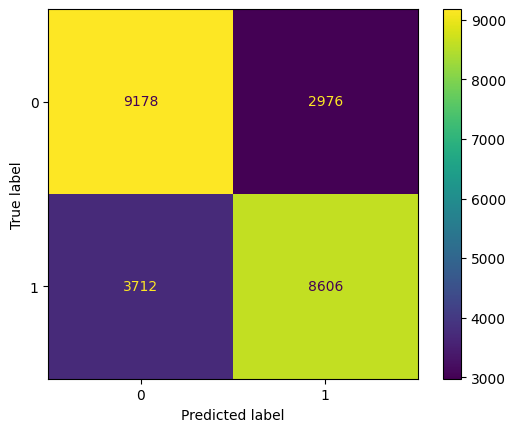

              precision    recall  f1-score   support

           0       0.71      0.76      0.73     12154
           1       0.74      0.70      0.72     12318

    accuracy                           0.73     24472
   macro avg       0.73      0.73      0.73     24472
weighted avg       0.73      0.73      0.73     24472

Validación: 0.7937218692854449
Train: 0.7953194328147319


In [115]:

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Crear una tubería (pipeline) con el escalador y el modelo de regresión logística
pipe = make_pipeline(StandardScaler(), LogisticRegression())

model = LogisticRegression()

param_grid = {
    'logisticregression__C': [0.1],
    # 'logisticregression__penalty': ['l2', None],
    'logisticregression__solver': ['lbfgs', 'liblinear', 'sag', 'saga'],
    # 'logisticregression__max_iter': [100, 200, 300],
    # 'logisticregression__tol': [1e-4, 1e-3, 1e-2],
    'logisticregression__class_weight': ['balanced'],
    'logisticregression__fit_intercept': [True]
}

# Crear el objeto GridSearchCV
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc')

# Ajustar el GridSearchCV con los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros encontrados
print(f"Mejores hiperparámetros: {grid_search.best_params_}")

# Evaluar el modelo con los mejores hiperparámetros en el conjunto de prueba
best_pipe = grid_search.best_estimator_

# Guardar las puntuaciones
scores = dict()
scores["Logistic Regression"] = best_pipe.score(X_test, y_test)

# Matriz de confusión
cm = confusion_matrix(y_test, best_pipe.predict(X_test))

# Mostrar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Imprimir el reporte de clasificación
print(classification_report(y_test, best_pipe.predict(X_test)))

# Validación cruzada
results = cross_validate(best_pipe, X_train, y_train, cv=5, return_train_score=True, scoring='roc_auc')

print('Validación:', results['test_score'].mean())
print('Train:', results['train_score'].mean())


0.7439931350114416


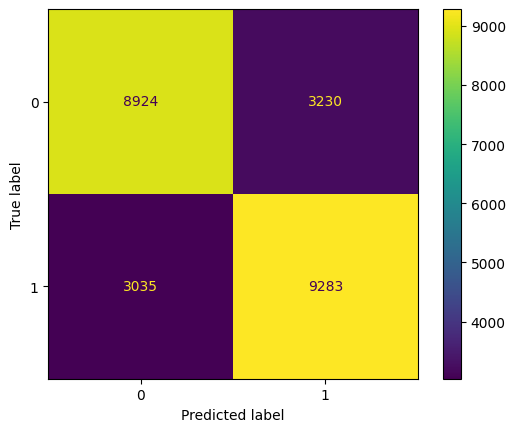

              precision    recall  f1-score   support

           0       0.75      0.73      0.74     12154
           1       0.74      0.75      0.75     12318

    accuracy                           0.74     24472
   macro avg       0.74      0.74      0.74     24472
weighted avg       0.74      0.74      0.74     24472



In [116]:

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

pipe = make_pipeline(StandardScaler(), RandomForestClassifier())
# pipe = make_pipeline(StandardScaler(), LogisticRegression())
# pipe = make_pipeline(MaxAbsScaler(), LogisticRegression())
# pipe = make_pipeline(StandardScaler(), HistGradientBoostingClassifier(max_iter=100, learning_rate=0.1))

pipe.fit(X_train, y_train)  # apply scaling on training data
scores["Random Forest Classifier"]= pipe.score(X_test, y_test)


print(pipe.score(X_test, y_test))  # 

cm = confusion_matrix(y_test, pipe.predict(X_test))

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()
print(classification_report(y_test, pipe.predict(X_test)))

0.7461997384766264


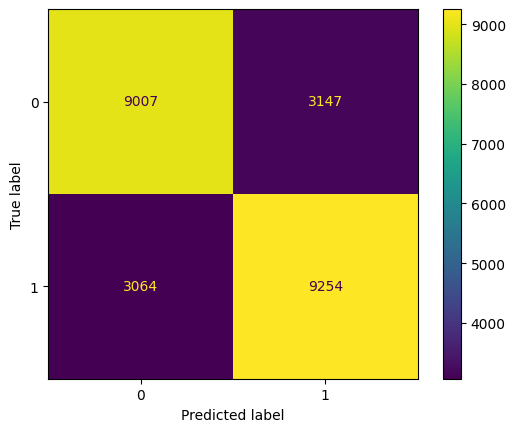

              precision    recall  f1-score   support

           0       0.75      0.74      0.74     12154
           1       0.75      0.75      0.75     12318

    accuracy                           0.75     24472
   macro avg       0.75      0.75      0.75     24472
weighted avg       0.75      0.75      0.75     24472



In [117]:

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# pipe = make_pipeline(StandardScaler(), RandomForestClassifier())
# pipe = make_pipeline(StandardScaler(), LogisticRegression())
# pipe = make_pipeline(MaxAbsScaler(), LogisticRegression())
pipe = make_pipeline(StandardScaler(), HistGradientBoostingClassifier(max_iter=100, learning_rate=0.1))

pipe.fit(X_train, y_train)  # apply scaling on training data
scores["HistGradientBoostingClassifier"] = pipe.score(X_test, y_test)

print(pipe.score(X_test, y_test))  # 

cm = confusion_matrix(y_test, pipe.predict(X_test))

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()
print(classification_report(y_test, pipe.predict(X_test)))

In [118]:

# X = df.drop(['calificacion'], axis=1)
# y = df['calificacion'] 

# Estandarizar las características
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelo de regresión
reg_model = LinearRegression()
reg_model.fit(X_train_scaled, y_train)

# Predecir en el conjunto de prueba
y_pred_reg = reg_model.predict(X_test_scaled)

# Calcular el error cuadrático medio (MSE)
mse = mean_squared_error(y_test, y_pred_reg)



print(f'Mean Squared Error (Regresión): {mse}')

# Modelo de clasificación
clf_model = RandomForestClassifier(random_state=42)
clf_model.fit(X_train, y_train)
y_pred_clf = clf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_clf)
print(f'Accuracy (Clasificación): {accuracy}')
scores["Random Forest 2"] = accuracy_score(y_test, y_pred_clf)
random_forest_accuracy = accuracy


# Print classification report
print(classification_report(y_test, y_pred_clf))


Mean Squared Error (Regresión): 0.18743516059193177
Accuracy (Clasificación): 0.7432984635501798
              precision    recall  f1-score   support

           0       0.75      0.73      0.74     12154
           1       0.74      0.75      0.75     12318

    accuracy                           0.74     24472
   macro avg       0.74      0.74      0.74     24472
weighted avg       0.74      0.74      0.74     24472



In [119]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# # Supongamos que df es tu DataFrame y 'calificacion' es la columna objetivo dicotómica

# # Dividir las características y la variable objetivo
# X = df.drop(['calificacion'], axis=1)
# y = df['calificacion']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelo de regresión logística
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

# Predecir en el conjunto de prueba
y_pred = log_reg.predict(X_test_scaled)

# Calcular la precisión y otros métricos
accuracy = accuracy_score(y_test, y_pred)
scores["Logistic Regression 2"] = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Imprimir el reporte de clasificación
print(classification_report(y_test, y_pred))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")


Accuracy: 0.7291347430789662
              precision    recall  f1-score   support

           0       0.71      0.76      0.73      9672
           1       0.75      0.70      0.72      9906

    accuracy                           0.73     19578
   macro avg       0.73      0.73      0.73     19578
weighted avg       0.73      0.73      0.73     19578

Confusion Matrix:
[[7336 2336]
 [2967 6939]]


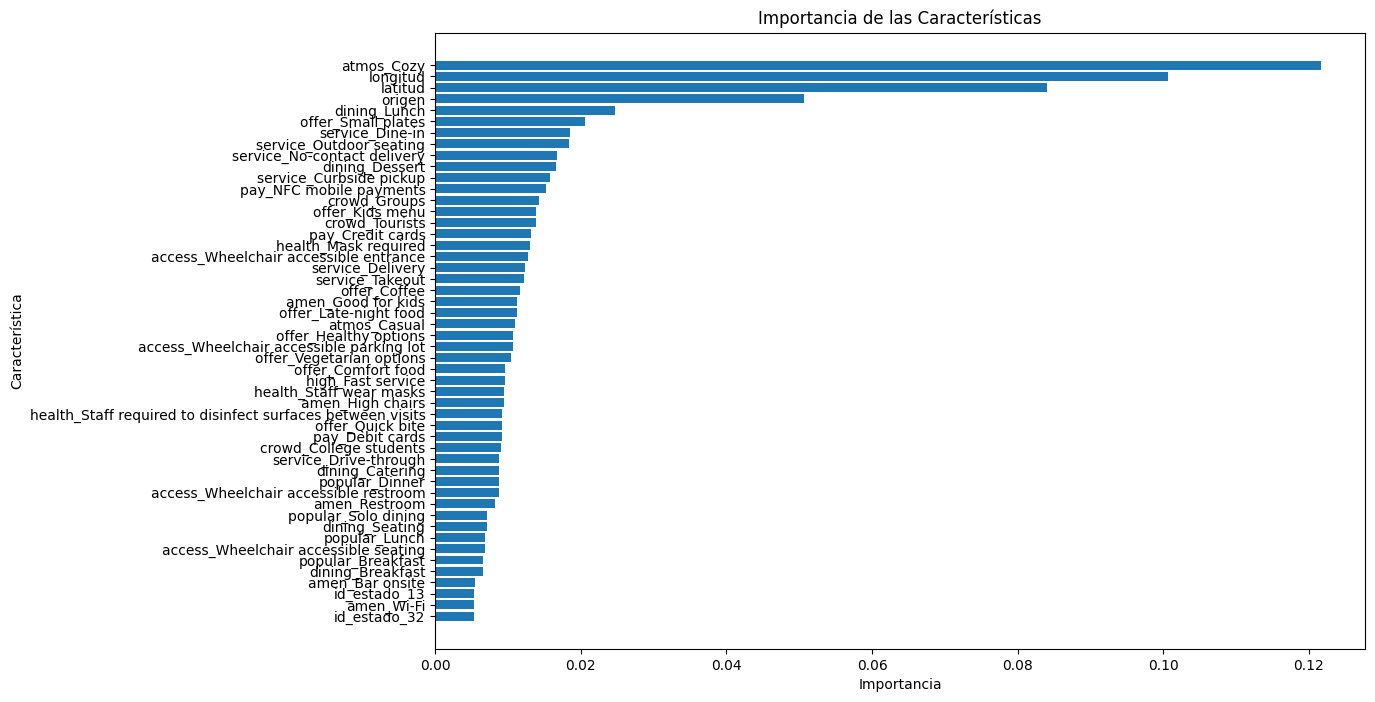

['atmos_Cozy', 'longitud', 'latitud', 'origen', 'dining_Lunch', 'offer_Small plates', 'service_Dine-in', 'service_Outdoor seating', 'service_No-contact delivery', 'dining_Dessert', 'service_Curbside pickup', 'pay_NFC mobile payments', 'crowd_Groups', 'offer_Kids menu', 'crowd_Tourists', 'pay_Credit cards', 'health_Mask required', 'access_Wheelchair accessible entrance', 'service_Delivery', 'service_Takeout', 'offer_Coffee', 'amen_Good for kids', 'offer_Late-night food', 'atmos_Casual', 'offer_Healthy options', 'access_Wheelchair accessible parking lot', 'offer_Vegetarian options', 'offer_Comfort food', 'high_Fast service', 'health_Staff wear masks', 'amen_High chairs', 'health_Staff required to disinfect surfaces between visits', 'offer_Quick bite', 'pay_Debit cards', 'crowd_College students', 'service_Drive-through', 'dining_Catering', 'popular_Dinner', 'access_Wheelchair accessible restroom', 'amen_Restroom', 'popular_Solo dining', 'dining_Seating', 'popular_Lunch', 'access_Wheelchai

In [136]:

model = DecisionTreeClassifier(random_state=42)
model.fit(X, y)

feature_importances = model.feature_importances_

features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Ordenar las características por importancia
features = features.sort_values(by='Importance', ascending=False).head(50)

# Visualizar la importancia de las características
plt.figure(figsize=(12, 8))
plt.barh(features['Feature'], features['Importance'])
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.title('Importancia de las Características')
plt.gca().invert_yaxis()
plt.show()

print(features['Feature'].tolist())

Accuracy (XGBoost): 0.7471651854121973


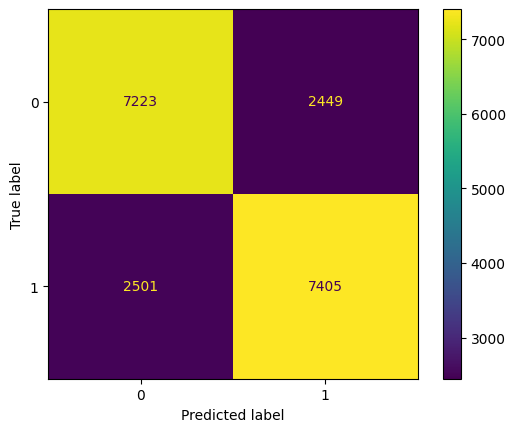

              precision    recall  f1-score   support

           0       0.74      0.75      0.74      9672
           1       0.75      0.75      0.75      9906

    accuracy                           0.75     19578
   macro avg       0.75      0.75      0.75     19578
weighted avg       0.75      0.75      0.75     19578



In [121]:

# Dividir los datos en conjuntos de entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

# Definir los parámetros del modelo
params = {
    'objective': 'multi:softmax',  # Para clasificación multiclase
    'num_class': 2,  # Número de clases en la variable de salida
    'eval_metric': 'merror',  # Métrica de evaluación
    'learning_rate': 0.1,
    'max_depth': 5
}

# Entrenar el modelo XGBoost
num_rounds = 300

xgb_model = xgb.train(params, dtrain, num_rounds)

# Hacer predicciones
y_pred_xgb = xgb_model.predict(dtest)

# Evaluar el modelo
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f'Accuracy (XGBoost): {accuracy_xgb}')
scores["Random Forest (XGBoost)"] = accuracy_score(y_test, y_pred_xgb)


# # Print classification report
# print(classification_report(y_test, y_pred_xgb))

cm = confusion_matrix(y_test, y_pred_xgb)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()
print(classification_report(y_test, y_pred_xgb))


In [123]:
# print(f"Columnas dropear {dropear}")
# print(f"random forest: {round(random_forest_accuracy*100, 3)}")
# print(f"linear reg   : {round(linear_reg_accuracy*100, 3)}" )
# print(f"xgboost      : {round(xgboost_accuracy*100, 3)}"  )

print(scores)

{'Logistic Regression': 0.7267080745341615, 'Random Forest Classifier': 0.7439931350114416, 'HistGradientBoostingClassifier': 0.7461997384766264, 'Random Forest 2': 0.7432984635501798, 'Logistic Regression 2': 0.7291347430789662, 'Random Forest (XGBoost)': 0.7471651854121973}


In [ ]:
# df_reviews = pd.read_parquet(r'Datawarehouse\reviewstexto.parquet')


- accesibilidad 10 columnas, 5 de yelp y 5 de google, (lift - elevator)
- beer - alcohol
- one hot encoding o level encoding a los estados
- crowd, family friend
- reseña, cloud, variables de peso
- balanceo de la variable target, min max scaler
- mapa mental de las categorías nuevas
- qué nuevos valores del ML agregar al Dashboard
- subir al datawarehouse las nuevas categorías


[I 2024-05-31 19:27:51,798] A new study created in memory with name: no-name-4b4437cd-1e26-4a40-a6a2-e60bdd59a626
[I 2024-05-31 19:28:04,348] Trial 0 finished with value: 0.7434056096012855 and parameters: {'learning_rate': 0.19145385197815437, 'max_depth': 4, 'min_child_weight': 4, 'gamma': 0.22572568492612266, 'subsample': 0.6881919930115311, 'colsample_bytree': 0.5938372287538833, 'n_estimators': 100}. Best is trial 0 with value: 0.7434056096012855.
[I 2024-05-31 19:28:24,225] Trial 1 finished with value: 0.7528349215596244 and parameters: {'learning_rate': 0.2963191052113705, 'max_depth': 10, 'min_child_weight': 1, 'gamma': 0.6928370092900277, 'subsample': 0.855558806865063, 'colsample_bytree': 0.5772395880131362, 'n_estimators': 148}. Best is trial 1 with value: 0.7528349215596244.
[I 2024-05-31 19:29:04,779] Trial 2 finished with value: 0.7470833279651743 and parameters: {'learning_rate': 0.026867075673976636, 'max_depth': 7, 'min_child_weight': 3, 'gamma': 0.87155017267695, 'sub

Best trial: 0.7542140544661798
Best parameters: {'learning_rate': 0.08759484786126097, 'max_depth': 9, 'min_child_weight': 9, 'gamma': 0.3183326182369449, 'subsample': 0.9829798466441388, 'colsample_bytree': 0.5279331027510189, 'n_estimators': 369}


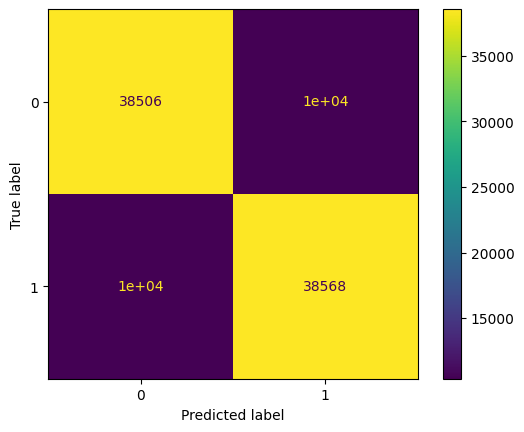

              precision    recall  f1-score   support

           0       0.79      0.79      0.79     48943
           1       0.79      0.79      0.79     48943

    accuracy                           0.79     97886
   macro avg       0.79      0.79      0.79     97886
weighted avg       0.79      0.79      0.79     97886



In [130]:
import optuna
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Asumiendo que X y y ya están definidos

# Escalar todo el dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

def objective(trial):
    params = {
        'objective': 'multi:softmax',
        'num_class': 2,
        'eval_metric': 'merror',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500)
    }

    xgb_model = xgb.XGBClassifier(**params)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(xgb_model, X_scaled, y, cv=cv, scoring='accuracy')
    return scores.mean()

# Crear el estudio y optimizar los hiperparámetros
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Imprimir los mejores parámetros encontrados por Optuna
print(f'Best trial: {study.best_trial.value}')
print(f'Best parameters: {study.best_trial.params}')

# Entrenar el modelo final con los mejores parámetros
best_params = study.best_trial.params
xgb_model = xgb.XGBClassifier(**best_params)
xgb_model.fit(X_scaled, y)

# Hacer predicciones en el mismo conjunto para obtener la matriz de confusión y el informe de clasificación
y_pred_xgb = xgb_model.predict(X_scaled)

# Matriz de confusión
cm = confusion_matrix(y, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Informe de clasificación
print(classification_report(y, y_pred_xgb))


In [128]:
%pip install ipywidgets widgetsnbextension pandas-profiling


     ---------------------------------------- 0.0/108.5 kB ? eta -:--:--
     ----------- ---------------------------- 30.7/108.5 kB ? eta -:--:--
     ------------------------ ------------ 71.7/108.5 kB 991.0 kB/s eta 0:00:01
     ------------------------------------ 108.5/108.5 kB 901.5 kB/s eta 0:00:00
  Using cached visions-0.7.6-py3-none-any.whl.metadata (11 kB)
  Using cached htmlmin-0.1.12-py3-none-any.whl
  Using cached phik-0.12.4-cp310-cp310-win_amd64.whl.metadata (5.6 kB)
  Using cached multimethod-1.11.2-py3-none-any.whl.metadata (9.1 kB)
  Using cached statsmodels-0.14.2-cp310-cp310-win_amd64.whl.metadata (9.5 kB)
  Using cached ImageHash-4.3.1-py2.py3-none-any.whl.metadata (8.0 kB)
  Using cached dacite-1.8.1-py3-none-any.whl.metadata (15 kB)
  Using cached numba-0.59.1-cp310-cp310-win_amd64.whl.metadata (2.8 kB)
  Using cached pywavelets-1.6.0-cp310-cp310-win_amd64.whl.metadata (9.0 kB)
  Using cached llvmlite-0.42.0-cp310-cp310-win_amd64.whl.metadata (4.9 kB)
  Using c

In [126]:
%pip install optuna


  Using cached alembic-1.13.1-py3-none-any.whl.metadata (7.4 kB)
  Using cached colorlog-6.8.2-py3-none-any.whl.metadata (10 kB)
  Using cached PyYAML-6.0.1-cp310-cp310-win_amd64.whl.metadata (2.1 kB)
   ---------------------------------------- 0.0/380.1 kB ? eta -:--:--
   --------- ------------------------------ 92.2/380.1 kB 2.6 MB/s eta 0:00:01
   ------------------------------ --------- 286.7/380.1 kB 2.9 MB/s eta 0:00:01
   ---------------------------------------- 380.1/380.1 kB 3.0 MB/s eta 0:00:00
Using cached alembic-1.13.1-py3-none-any.whl (233 kB)
Using cached colorlog-6.8.2-py3-none-any.whl (11 kB)
Using cached PyYAML-6.0.1-cp310-cp310-win_amd64.whl (145 kB)
   ---------------------------------------- 0.0/78.6 kB ? eta -:--:--
   ---------------------------------------- 78.6/78.6 kB 4.3 MB/s eta 0:00:00
